<h2>Imports</h2>

In [1]:
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, BatchNormalization, Dropout
from keras.models import load_model, Model
import pickle
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

from configuration import PATH_TO_WORDS, PATH_TO_SAVED_FOLDER, IMAGE_WIDTH, IMAGE_HEIGHT, PADDING_TOKEN, BATCH_SIZE, TRAIN_SIZE, PATH_TO_IMAGES

<h2>Some constants</h2>

In [2]:
words_metadata = PATH_TO_WORDS + '\\words_new.txt'
image_shape = (IMAGE_WIDTH, IMAGE_HEIGHT)
epochs = 50

write = False

<h2>Read dataset</h2>

In [3]:
if write:
    words = []
    with open(words_metadata, "r") as file:
        for line in file:
            if line[0] != "#":
                image_data = line.split(' ')
                image_name = image_data[0]
                word = image_data[8].strip()
                image_name_splitted = line.split('-')
                path_to_image_directory = os.path.join(PATH_TO_IMAGES, image_name_splitted[0], image_name_splitted[0] + '-' + image_name_splitted[1])
                path_to_image = os.path.join(path_to_image_directory, image_name + '.png')
                if os.path.getsize(path_to_image):
                    words.append((path_to_image, word))

    np.random.shuffle(words)
    np.save(PATH_TO_SAVED_FOLDER + '\\words.npy', words)
else:
    words = np.load(PATH_TO_SAVED_FOLDER + '\\words.npy')

print('Total number of words:', len(words))

Total number of words: 44563


<h2>Split dataset</h2>

In [4]:
if write:
    index_train = int(len(words) * TRAIN_SIZE)
    index_test = int(len(words) * (TRAIN_SIZE + (1 - TRAIN_SIZE) / 2))

    train = words[:index_train]
    test = words[index_train:index_test]
    validation = words[index_test:]

    np.save(PATH_TO_SAVED_FOLDER + '\\train.npy', train)
    np.save(PATH_TO_SAVED_FOLDER + '\\test.npy', test)
    np.save(PATH_TO_SAVED_FOLDER + '\\validation.npy', validation)
else:
    train = np.load(PATH_TO_SAVED_FOLDER + '\\train.npy')
    test = np.load(PATH_TO_SAVED_FOLDER + '\\test.npy')
    validation = np.load(PATH_TO_SAVED_FOLDER + '\\validation.npy')

print('Total number of train words:', len(train))
print('Total number of test words:', len(test))
print('Total number of validation words:', len(validation))

Total number of train words: 35650
Total number of test words: 4456
Total number of validation words: 4457


<h2>Collect vocabulary of unique symbols</h2>

In [5]:
if write:
    symbols = set()
    max_len = 0
    max_label = ''

    for image_path, label in train:
        for s in label:
            symbols.add(s)

        max_len = max(max_len, len(label))
        if len(label) ==  max_len :
            max_label = label

    symbols = sorted(list(symbols))
    with open(PATH_TO_SAVED_FOLDER + '\\symbols.pkl', 'wb') as file:
        pickle.dump({'symbols': symbols, 'max_len': max_len, 'longest': max_label}, file)
else:
    with open(PATH_TO_SAVED_FOLDER + '\\symbols.pkl', 'rb') as file:
        data = pickle.load(file)
        symbols, max_len, max_label = data['symbols'], data['max_len'], data['longest']


print("Maximum length: ", max_len)
print("The longest word: ", max_label)
print("Vocab size: ", len(symbols))

Maximum length:  19
The longest word:  brilliantly-written
Vocab size:  76


In [6]:
num_by_symbol = StringLookup(vocabulary=list(symbols), mask_token=None)
symbol_by_num = StringLookup(vocabulary=num_by_symbol.get_vocabulary(), mask_token=None, invert=True)

<h2>Prepare data (load and preprocess images and labels)</h2>

In [7]:
def preprocess_image(image_path, img_size=image_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)

    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0]])

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    image = tf.cast(image, tf.float32) / 255.0
    return image


def label_to_vector(label):
    label = num_by_symbol(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=PADDING_TOKEN)
    return label


def process_data(data):
    image = preprocess_image(data[0])
    label = label_to_vector(data[1])
    return {"image": image, "label": label, "path": data[0]}


def prepare_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices(data).map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


train_dataset = prepare_dataset(train)
validation_dataset = prepare_dataset(validation)
test_dataset = prepare_dataset(test)

<h2>Model classes</h2>

In [8]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = keras.Input(shape=(image_shape[0], image_shape[1], 1), name="image")
    labels = Input(name="label", shape=(None,))

    x = Conv2D(32,(5, 5),activation="relu")(input_img)
    x = Conv2D(64,(5, 5),activation="relu")(x)

    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3),activation="relu")(x)
    x = Conv2D(512, (3, 3),activation="relu")(x)
    x = Conv2D(1024,(3, 3),activation="relu")(x)

    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    new_shape = (x.shape[1], x.shape[2] * 1024)

    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)

    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    x = Dense(len(num_by_symbol.get_vocabulary()) + 2, activation="softmax", name="output")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 124, 28, 32)  832         ['image[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 120, 24, 64)  51264       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 24, 64)  256        ['conv2d_1[0

<h2>Build and train model</h2>

In [9]:
if write:
    model = build_model()
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="output").output)
    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)
    model.save(PATH_TO_SAVED_FOLDER + '\\Model.h5')
    with open('history.pickle', 'wb') as file:
        pickle.dump(history.history, file)
else:
    with keras.utils.custom_object_scope({'CTCLayer': CTCLayer}):
        model = load_model(PATH_TO_SAVED_FOLDER + '\\Model.h5')

<h2>Predict on test dataset</h2>

In [10]:
def decode_predictions(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    results = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(symbol_by_num(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def decode_labels(labels):
    decoded_labels = []
    for label in labels:
        label_without_padding = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
        decoded_labels.append(tf.strings.reduce_join(symbol_by_num(label_without_padding)).numpy().decode("utf-8"))
    return decoded_labels


if write:
    predictions, labels, images = [], [], []
    prediction_model = Model(model.get_layer(name="image").input, model.get_layer(name="output").output)
    for test_word in test_dataset:
        predictions += decode_predictions(prediction_model.predict(test_word['image']))
        labels += decode_labels(test_word['label'].numpy().tolist())
        images += test_word['path'].numpy().tolist()
    with open(PATH_TO_SAVED_FOLDER + '\\predictions.pkl', 'wb') as file:
        pickle.dump({'predictions': predictions, 'labels': labels, 'images': images}, file)
else:
    with open(PATH_TO_SAVED_FOLDER + '\\predictions.pkl', 'rb') as file:
        data = pickle.load(file)
        predictions, labels, images = data['predictions'], data['labels'], data['images']

<h2>Check predictions</h2>

True text: Peter
Predicted text: Peter


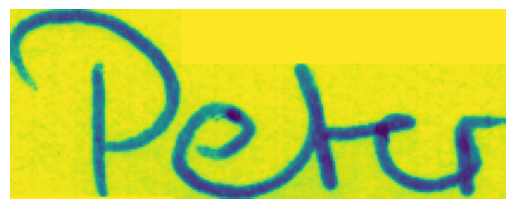

In [14]:
def show_random_prediction():
    id = random.randint(0, len(predictions))
    print(f'True text: {labels[id]}')
    print(f'Predicted text: {predictions[id]}')

    image = mpimg.imread(images[id])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

show_random_prediction()

<h2>Evaluate predictions</h2>

In [12]:
total_count = 0
correct_count = 0

total_symbols = 0
correct_symbols = 0

for i in range(len(predictions)):
    total_count = total_count + 1
    total_symbols += len(labels[i])
    if labels[i] == predictions[i]:
        correct_count = correct_count+1
        correct_symbols += len(labels[i])
    else:
        for j in range(min(len(labels[i]), len(predictions[i]))):
            if labels[i][j] == predictions[i][j]:
                correct_symbols += 1


print("Total count of words: ", total_count)
print("Count of correctly predicted words: ", correct_count)
print(f"Percentage : {(correct_count / total_count) * 100}% .")

print("\nTotal count of words: ", total_symbols)
print("Count of correctly predicted symbols: ", correct_symbols)
print(f"Percentage : {(correct_symbols / total_symbols) * 100}% .")

Total count of words:  4456
Count of correctly predicted words:  3029
Percentage : 67.97576301615798% .

Total count of words:  19048
Count of correctly predicted symbols:  15423
Percentage : 80.96913061738765% .
